# Глубинное обучение 1 / Введение в глубинное обучение, ФКН ВШЭ

## Домашнее задание 2: сверточный классификатор.

### Общая информация

Оценка после штрафа после мягкого дедлайна вычисляется по формуле $M_{\text{penalty}} = M_{\text{full}} \cdot 0.85^{t/1440}$, где $M_{\text{full}}$ — полная оценка за работу без учета штрафа, а $t$ — время в минутах, прошедшее после мягкого дедлайна (округление до двух цифр после запятой). Таким образом, спустя первые сутки после мягкого дедлайна вы не можете получить оценку выше 8.5, а если сдать через четыре дня после мягкого дедлайна, то ваш максимум — 5.22 балла.

### Оценивание и штрафы

Максимально допустимая оценка за работу — 10 баллов. Сдавать задание после указанного срока сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке. Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

### О задании

В этом задании вам предстоит познакомиться со сверточными сетями и их обучением для классификации изображений с использованием библиотеки PyTorch.


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split

## 0. Загрузка данных

Работать мы будем с набором данных [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html). CIFAR10 представляет собой набор изображений 32х32 пикселя, разделенных на 10 классов.

![title](https://pytorch.org/tutorials/_images/cifar10.png)




Набор данных уже определен в <code>torchvision.datasets</code>, так что возьмем его оттуда. 



In [26]:
def get_cifar10_data(batch_size, transform_train):
    torch.manual_seed(0)
    np.random.seed(0)

    transform_test = torchvision.transforms.Compose(
        [torchvision.transforms.ToTensor(),
         # Переводим цвета пикселей в отрезок [-1, 1]
         torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )
    
    # Загружаем данные
    trainvalset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                               download=True, transform=transform_train)
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform_test)
    
    # В датасете определено разбиение только на train и test,
    # так что валидацию дополнительно выделяем из обучающей выборки
    train_idx, valid_idx = train_test_split(np.arange(len(trainvalset)), test_size=0.3, 
                                            shuffle=True, random_state=0)
    trainset = torch.utils.data.Subset(trainvalset, train_idx)
    valset = torch.utils.data.Subset(trainvalset, valid_idx)

    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               shuffle=True, num_workers=2)
    val_loader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                             shuffle=False, num_workers=2)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                              shuffle=False, num_workers=2)
    
    return train_loader, val_loader, test_loader
    

In [3]:
transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, 
                                                         transform_train=transform)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Посмотрим на изображения:

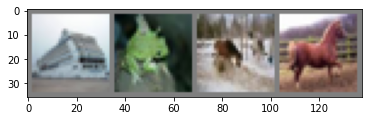

ship frog horse horse


In [4]:
def imshow(img):
    img = img / 2 + 0.5    
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(train_loader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images[:4]))

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
print(*[classes[labels[i]] for i in range(4)])

## 1. Задание сверточной сети (3 балла)

Теперь нам нужно задать сверточную нейронную сеть, которую мы будем обучать классифицировать изображения.

Используем сеть, основанную на одном блоке архитектуры ResNet.

<img src="https://i.ibb.co/2hg962h/basic-block.png" width="500"/>

__Указания:__

- Все сверточные слои должны иметь 32 выходных канала, а также не должны изменять ширину и высоту изображения.
- Выход блока сократите до размерности 32х4х4, применив average pooling.
- Для получения итоговых логитов, распрямите выход пулинга в вектор из 512 элементов, а затем пропустите его через линейный слой.

**Задание 1.1 (3 балла).**

Определите архитектуру сети соответственно схеме и указаниям выше.

Ключевые слова: <code>Conv2d</code>, <code>BatchNorm2d</code>, <code>AvgPool2d</code>.

In [5]:
n_classes = 10

class BasicBlockNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
        )
        self.avg = nn.AvgPool2d(8)
        self.l = nn.Linear(512, 10)
        self.relu = nn.ReLU()
        self.block = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=1)


    def forward(self, x):
        out = self.encoder(x) + self.block(x)
        out = self.relu(out)
        out = self.avg(out)
        out = torch.flatten(out, 1)
        out = self.l(out)
        
        return out

In [6]:
net = BasicBlockNet()
net

BasicBlockNet(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (avg): AvgPool2d(kernel_size=8, stride=8, padding=0)
  (l): Linear(in_features=512, out_features=10, bias=True)
  (relu): ReLU()
  (block): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1))
)

Проверим, что выход сети имеет корректную размерность:

In [8]:
assert net(torch.zeros((10, 3, 32, 32))).shape == (10, 10)

Чтобы проводить вычисления на GPU, в PyTorch необходимо руками перекладывать объекты, с которыми вы хотите проводить вычисления, на графический ускоритель. Это делается следующим образрм:

In [7]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [8]:
net = net.to(device)

Подключение GPU в google.colab:

**Среда выполнения** -> **Сменить среду выполнения** -> **Аппаратный ускоритель** -> **GPU**

## 2. Обучение и тестирование модели (3 балла)

**Задание 2.1 (2 балла).** Переходим к обучению модели. Заполните пропуски в функциях <code>test</code> и <code>train_epoch</code>. В качестве функции потерь будем использовать [кросс-энтропию](https://pytorch.org/docs/stable/generated/torch.nn.functional.cross_entropy.html), а в качестве метрики качества accuracy.

In [40]:
import torch
import torchmetrics

def test(model, loader):
    loss_log = []
    acc_log = []
    model.eval()
    accuracy = torchmetrics.Accuracy().to(device)
    lossfunc = nn.CrossEntropyLoss()
    
    for data, target in loader:
        data = data.to(device)
        target = target.to(device)
        
        x = model(data)
        loss = lossfunc(x, target)
        
        loss_log.append(loss.item())
        
        # <your code here>
        
        acc = accuracy(x, target)
        
        acc_log.append(acc.item()) 
        
    return np.mean(loss_log), np.mean(acc_log)

def train_epoch(model, optimizer, train_loader):
    loss_log = []
    acc_log = []
    model.train()
    accuracy = torchmetrics.Accuracy().to(device)
    lossfunc = nn.CrossEntropyLoss()
    
    for data, target in train_loader:
        data = data.to(device)
        target = target.to(device)
        
        # <your code here>
        optimizer.zero_grad()
        
        x = model(data)
        loss = lossfunc(x, target)
        
        loss_log.append(loss.item())
        
        loss.backward()
        optimizer.step()
        
        # <your code here>
        
        acc = accuracy(x, target)
        acc_log.append(acc.item()) 

    return loss_log, acc_log

def train(model, optimizer, n_epochs, train_loader, val_loader, scheduler=None):
    train_loss_log, train_acc_log, val_loss_log, val_acc_log = [], [], [], []

    for epoch in range(n_epochs):
        train_loss, train_acc = train_epoch(model, optimizer, train_loader)
        val_loss, val_acc = test(model, val_loader)
        
        train_loss_log.extend(train_loss)
        train_acc_log.extend(train_acc)
        
        val_loss_log.append(val_loss)
        val_acc_log.append(val_acc)

        print(f"Epoch {epoch}")
        print(f" train loss: {np.mean(train_loss)}, train acc: {np.mean(train_acc)}")
        print(f" val loss: {val_loss}, val acc: {val_acc}\n")
        
        if scheduler is not None:
            scheduler.step()

    return train_loss_log, train_acc_log, val_loss_log, val_acc_log

Запустим обучение модели. В качестве оптимизатора будем использовать стохастический градиентный спуск, который является де-факто стандартом в задачах компьютерного зрения (наравне с <code>Adam</code>).

__Замечание:__ Для достижения наилучшего качества в нашем случае потребуется обучать модель несколько сотен эпох. Однако в целях экономии вашего времени и сил, во всех экспериментах мы ограничимся 20 эпохами.

In [34]:
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
train_loss_log, train_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader)

Epoch 0
 train loss: 0.8183312672692635, train acc: 0.7155711347921675
 val loss: 0.8801270992197889, val acc: 0.6970744680851064

Epoch 1
 train loss: 0.8031785762724101, train acc: 0.721116805970124
 val loss: 0.9495400436381076, val acc: 0.6720079787234042

Epoch 2
 train loss: 0.7921730130093625, train acc: 0.7274378101176274
 val loss: 0.8616859300339476, val acc: 0.7048980497299356

Epoch 3
 train loss: 0.7741366335526245, train acc: 0.7302575737946212
 val loss: 0.8858778330873935, val acc: 0.6994902481424048

Epoch 4
 train loss: 0.7677859463465061, train acc: 0.7342117719720007
 val loss: 0.888698592591793, val acc: 0.7021941489361702

Epoch 5
 train loss: 0.7560067878562746, train acc: 0.7384393770908307
 val loss: 0.8366051389815959, val acc: 0.7168661348363187

Epoch 6
 train loss: 0.750324384277002, train acc: 0.7381578087806702
 val loss: 0.8964073174811424, val acc: 0.6962101063829788

Epoch 7
 train loss: 0.7486326343071744, train acc: 0.7408755550218893
 val loss: 0.86

Посчитайте точность на тестовой выборке:

In [13]:
loss, acc = test(net, test_loader)
print(loss, acc)

0.9095955466388896 0.6860071656050956


Если вы все сделали правильно, у вас должна была получиться точность $\ge 67\%$.

**Задание 2.2 (1 балл).** Постройте графики зависимости функции потерь и точности классификации от номера шага оптимизатора. На каждом графике расположите данные и для обучающей и для валидационной выборки, итого у вас должно получиться два графика. Обратите внимание, что на обучающей выборке эти данные считаются по каждому батчу, на валидационной же они считаются по всей выборке раз в эпоху.

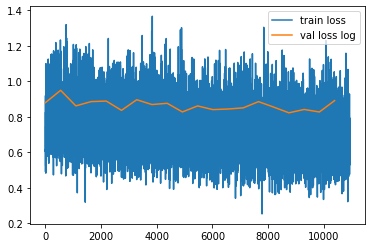

In [37]:
plt.plot(train_loss_log, label='train loss log')
plt.plot(range(0, len(train_loss_log), len(train_loss_log) // len(val_loss_log)), val_loss_log, label='val loss log')
plt.legend()
plt.show()

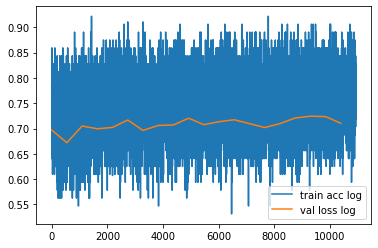

In [38]:
plt.plot(train_acc_log, label='train acc log')
plt.plot(range(0, len(train_acc_log), len(train_acc_log) // len(val_acc_log)), val_acc_log, label='val loss log')
plt.legend()
plt.show()

## 3. Расписание длины шага (2 балла)

С курса "Машинное обучение 1" вы уже должны знать, что сходимость стохастического градиентного спуска мы можем теоретически гарантировать только если будем определенным образом со временем уменьшать длину шага. На практике при обучении нейронных сетей такая техника оказывается очень полезной, однако теоретически обоснованными способами уменьшения длины шага фантазия не ограничивается.

Одним из простейших способов является кусочно постоянная функция: на нескольких фиксированных эпохах уменьшаем длину шага в константу раз.

In [16]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Epoch 0
 train loss: 1.4933056048980797, train acc: 0.46646072735952065
 val loss: 1.3414000724224333, val acc: 0.5203014183551707

Epoch 1
 train loss: 1.1759668065599376, train acc: 0.5872208800786592
 val loss: 1.136753463998754, val acc: 0.598359929120287

Epoch 2
 train loss: 1.0649669976731324, train acc: 0.6303702010968921
 val loss: 1.1157312583416066, val acc: 0.6118794327086591

Epoch 3
 train loss: 1.0023253038116957, train acc: 0.6514592582608489
 val loss: 0.993080560704495, val acc: 0.6548980497299357

Epoch 4
 train loss: 0.9591636824433503, train acc: 0.6674474405850092
 val loss: 0.989999269170964, val acc: 0.6543218085106383

Epoch 5
 train loss: 0.9248054395319121, train acc: 0.6803587751371115
 val loss: 0.9735324268645429, val acc: 0.6625664893617021

Epoch 6
 train loss: 0.905458379652644, train acc: 0.6828031144368801
 val loss: 0.9169622667292331, val acc: 0.6810505319148936

Epoch 7
 train loss: 0.8815508631945093, train acc: 0.6933843692870201
 val loss: 0.896

Посчитайте точность на тестовой выборке:

In [17]:
loss, acc = test(net, test_loader)
print(loss, acc)

0.8267471327143869 0.7178542993630573


**Задание 3.0 (0.5 баллов).** Здесь может возникнуть вопрос: а что будет, если мы не будем уменьшать длину шага в процессе обучения, а сразу возьмем констатную, равную значению нашей кусочно-постоянной функции на последних эпохах, то есть $0.001$ в нашем случае. Запустите обучение и проверьте, что в таком случае мы получим худшее качество на тестовой выборке.

In [18]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Epoch 0
 train loss: 1.5340507102404914, train acc: 0.44756300603014026
 val loss: 1.3351156452868846, val acc: 0.5179964538584364

Epoch 1
 train loss: 1.232183578790215, train acc: 0.5622714808043876
 val loss: 1.1933475116465955, val acc: 0.5858377659574469

Epoch 2
 train loss: 1.0910657107067283, train acc: 0.6187932554503027
 val loss: 1.1015837585672419, val acc: 0.6137854609083622

Epoch 3
 train loss: 1.0229188375978626, train acc: 0.641388090916482
 val loss: 0.9951596465516598, val acc: 0.6544769502700644

Epoch 4
 train loss: 0.9766154824270845, train acc: 0.6593513319871543
 val loss: 0.9716077487519447, val acc: 0.6622562055892133

Epoch 5
 train loss: 0.9435892913633552, train acc: 0.6721116805643225
 val loss: 0.9353941077881671, val acc: 0.6767952127659574

Epoch 6
 train loss: 0.9200401050081201, train acc: 0.6802975646538534
 val loss: 0.9157908675518441, val acc: 0.680718085106383

Epoch 7
 train loss: 0.8998426611942173, train acc: 0.6891159572156735
 val loss: 0.9

In [19]:
loss, acc = test(net, test_loader)
print(loss, acc)

0.8387860936723697 0.7086982484076433


**Задание 3.1 (1.5 балла).** Изучите, какие еще способы уменьшения длины шага представлены в <code>torch.optim.lr_scheduler</code>. Выберите несколько из них, объясните, как они устроены, и обучите модель с ними. Удалось ли добиться улучшения качества на тестовой выборке?

In [20]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Epoch 0
 train loss: 1.4880903670513217, train acc: 0.46926008750577297
 val loss: 1.347588640324613, val acc: 0.5290115248649678

Epoch 1
 train loss: 1.1561705413422594, train acc: 0.5959535779421247
 val loss: 1.0757943110263093, val acc: 0.6242464539852548

Epoch 2
 train loss: 1.0511435336778978, train acc: 0.6327614912821127
 val loss: 1.0251216878282263, val acc: 0.646719858240574

Epoch 3
 train loss: 0.9869232831533038, train acc: 0.6555154739829696
 val loss: 1.050060899714206, val acc: 0.6314716311211281

Epoch 4
 train loss: 0.9453340712151536, train acc: 0.6710302950695184
 val loss: 0.9965179641196068, val acc: 0.6502216311211282

Epoch 5
 train loss: 0.9093095005321329, train acc: 0.6834274614314928
 val loss: 1.0019363700075352, val acc: 0.6600620566530431

Epoch 6
 train loss: 0.8855401905188831, train acc: 0.6941229759884054
 val loss: 0.9501523674802578, val acc: 0.6761746454746165

Epoch 7
 train loss: 0.8604439868569592, train acc: 0.7022517301700669
 val loss: 0.9

In [21]:
loss, acc = test(net, test_loader)
print(loss, acc)

0.832590386746036 0.7143710191082803


In [26]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=0.5, total_iters=4)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Epoch 0
 train loss: 1.4792220977150325, train acc: 0.4721043353433801
 val loss: 1.3260900555772985, val acc: 0.5272384751350322

Epoch 1
 train loss: 1.1912954886609066, train acc: 0.5780841930474834
 val loss: 1.179739906179144, val acc: 0.5833998226104898

Epoch 2
 train loss: 1.0857518609524646, train acc: 0.6206377317526223
 val loss: 1.120511786988441, val acc: 0.6103280140998516

Epoch 3
 train loss: 1.0269964899615789, train acc: 0.6415921258969978
 val loss: 1.0273658864041593, val acc: 0.6423980497299356

Epoch 4
 train loss: 0.9922444392165929, train acc: 0.6565805367403535
 val loss: 1.034588623046875, val acc: 0.6451684396317665

Epoch 5
 train loss: 0.9488692700971851, train acc: 0.6702957691614545
 val loss: 1.0237750880261685, val acc: 0.6409352837724889

Epoch 6
 train loss: 0.9184006366476934, train acc: 0.6812320449670446
 val loss: 0.9208849726839269, val acc: 0.6797650710065314

Epoch 7
 train loss: 0.8954493511311533, train acc: 0.6878550208464836
 val loss: 1.00

In [27]:
loss, acc = test(net, test_loader)
print(loss, acc)

0.9338682491308564 0.6879976114649682


In [15]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 15, eta_min=0, last_epoch=- 1, verbose=False)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

loss, acc = test(net, test_loader)
print(loss, acc)

Epoch 0
 train loss: 1.506139678536647, train acc: 0.46311455338485064
 val loss: 1.2494444456506282, val acc: 0.5534796099713508

Epoch 1
 train loss: 1.2040145393917285, train acc: 0.5770558566672275
 val loss: 1.1970557268629682, val acc: 0.5875

Epoch 2
 train loss: 1.079046443023019, train acc: 0.6243103617288077
 val loss: 1.1511907293441448, val acc: 0.6044769503968828

Epoch 3
 train loss: 1.0258501807340101, train acc: 0.6436569600262197
 val loss: 1.0085649112437634, val acc: 0.6505762412192974

Epoch 4
 train loss: 0.9789504340187505, train acc: 0.6622894358373429
 val loss: 0.9672689825930494, val acc: 0.6628102837724889

Epoch 5
 train loss: 0.9381625018128529, train acc: 0.6724585400420962
 val loss: 0.9632640957832337, val acc: 0.671343085106383

Epoch 6
 train loss: 0.9113246878060823, train acc: 0.6851087098147794
 val loss: 0.9336524651405659, val acc: 0.6773271276595745

Epoch 7
 train loss: 0.8844823908108462, train acc: 0.6918173805015396
 val loss: 0.9041333259420

In [16]:
loss, acc = test(net, test_loader)
print(loss, acc)

0.838351351060685 0.7117834394904459


Your answers here:

## 4. Аугментации данных (2 балла)

Еще одной стандартной техникой, применяющейся в глубинном обучении, а особенно часто в компьютерном зрении, являются аугментации данных. Суть аугментаций состоит в том, что мы можем некоторым синтетическим образом видоизменять объекты обучающей выборки, тем самым расширяя ее, а также делая итоговую модель более устойчивой к таким изменениям.

Простейшая аугментация, которую можно применить к картинкам — разворот картинки по горизонтальной оси. То есть при обучении модели с вероятностью $0.5$ мы будем разворачивать картинку из обучающей выборки.

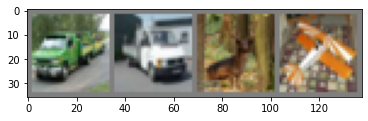

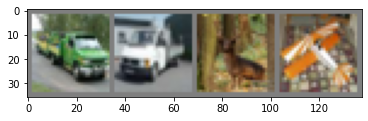

In [11]:
dataiter = iter(train_loader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images[:4]))

imshow(torchvision.utils.make_grid(transforms.functional.hflip(images[:4])))

Наиболее удобным способом работы с аугментациями в PyTorch является их задание в списке <code>transforms</code>, который затем передается в загрузчик данных. Обучим нашу сеть, применяя горизонтальные повороты:

In [13]:
transform = transforms.Compose(
        [transforms.RandomHorizontalFlip(),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Files already downloaded and verified
Files already downloaded and verified
Epoch 0
 train loss: 1.454427204249764, train acc: 0.4842974666703554
 val loss: 1.2404946362718623, val acc: 0.5561170212765958

Epoch 1
 train loss: 1.1502686993949374, train acc: 0.5989651345465693
 val loss: 1.0888510627949493, val acc: 0.621498226865809

Epoch 2
 train loss: 1.05150788858996, train acc: 0.6339285714752714
 val loss: 1.0682115876928289, val acc: 0.6313608156873824

Epoch 3
 train loss: 1.0009548960481744, train acc: 0.6520509597806216
 val loss: 1.0407878589122854, val acc: 0.6404476949509154

Epoch 4
 train loss: 0.9679776946630949, train acc: 0.6635626142595978
 val loss: 1.0071518542918754, val acc: 0.6508421986661059

Epoch 5
 train loss: 0.9303948597018854, train acc: 0.6768942609347635
 val loss: 0.9207498963843, val acc: 0.6793661348363187

Epoch 6
 train loss: 0.9084268142579897, train acc: 0.6863900496057445
 val loss: 0.9494593785164204, val acc: 0.6708554965384463

Epoch 7
 train

Посчитайте точность на тестовой выборке:

In [14]:
loss, acc = test(net, test_loader)
print(loss, acc)

0.8031723899826123 0.7240246815286624


**Задание 4.1 (2 балла).** Изучите, какие еще способы аугментаций изображений представлены в <code>torchvision.transforms</code>. Выберите несколько из них, объясните, как они устроены, и обучите модель с ними (по отдельности и вместе). Удалось ли добиться улучшения качества на тестовой выборке?

In [29]:
transform2 = torchvision.transforms.Compose(
        [torchvision.transforms.RandomVerticalFlip(p=0.5),
         torchvision.transforms.RandomInvert(p=0.5),
         torchvision.transforms.ToTensor(),
         torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform2)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)


Files already downloaded and verified
Files already downloaded and verified
Epoch 0
 train loss: 1.8743452256514779, train acc: 0.31909849177330896
 val loss: 1.6704160999744497, val acc: 0.3911790780564572

Epoch 1
 train loss: 1.5657837534735364, train acc: 0.44151540876960405
 val loss: 1.5500218178363556, val acc: 0.4417553191489362

Epoch 2
 train loss: 1.4530154979860979, train acc: 0.4863500587465122
 val loss: 1.43226924094748, val acc: 0.487876773134191

Epoch 3
 train loss: 1.3881607627737893, train acc: 0.5069453512510826
 val loss: 1.556225373389873, val acc: 0.46338652486496784

Epoch 4
 train loss: 1.3483628481354095, train acc: 0.5253493079210766
 val loss: 1.4514939815440075, val acc: 0.49168882978723405

Epoch 5
 train loss: 1.325796979545893, train acc: 0.5324456450926103
 val loss: 1.3388061629964951, val acc: 0.524423758907521

Epoch 6
 train loss: 1.2963336146073978, train acc: 0.5433288717836523
 val loss: 1.2852870710352633, val acc: 0.5465425531914894

Epoch 7
 

In [30]:
loss, acc = test(net, test_loader)
print(loss, acc)

1.1422358022373953 0.6033041401273885


In [31]:
transform2 = torchvision.transforms.Compose(
        [torchvision.transforms.RandomAdjustSharpness(1.5, p=0.5),
         torchvision.transforms.RandomAutocontrast(p=0.5),
         torchvision.transforms.ToTensor(),
         torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform2)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)


Files already downloaded and verified
Files already downloaded and verified
Epoch 0
 train loss: 1.4719756965881292, train acc: 0.4823509728232947
 val loss: 1.2575008607925253, val acc: 0.5448803191489362

Epoch 1
 train loss: 1.1508455886701343, train acc: 0.5973859035990574
 val loss: 1.0637279538398092, val acc: 0.6286347518575952

Epoch 2
 train loss: 1.0425107398460292, train acc: 0.637739945155393
 val loss: 1.0121271270386716, val acc: 0.6520390071767441

Epoch 3
 train loss: 0.9825782842348437, train acc: 0.6601348263254113
 val loss: 0.9635593109942497, val acc: 0.6678856382978723

Epoch 4
 train loss: 0.9381851055940282, train acc: 0.6753027879341865
 val loss: 1.00313076770052, val acc: 0.6465647163543295

Epoch 5
 train loss: 0.9097826220435677, train acc: 0.6860962392425188
 val loss: 0.9961446604830153, val acc: 0.655629432708659

Epoch 6
 train loss: 0.8844251146155258, train acc: 0.6913725842723463
 val loss: 0.9227861145709423, val acc: 0.6809397162275111

Epoch 7
 tr

In [32]:
loss, acc = test(net, test_loader)
print(loss, acc)

0.8151623181476715 0.7185509554140127


Your answers here: все манипуляции дают примерно такой же ответ как и процессинг без траснформов

## Бонус. Логирование в wandb (2 балла)

На практике специалиста по глубинному обучению часто встречаются ситуации, когда нейросеть учится на каком-то удаленном сервере. И обычно вам хочется отслеживать прогресс обучения, особенно когда время обучения модели исчисляется днями или неделями. Для таких целей существует несколько инструментов. Вероятно, самый популярный из них — [wandb](https://wandb.ai/site).

Ваша задача состоит в том, чтобы разобраться как им пользоваться, и повторить задания 2.1 и 2.2 с его использованием. Обучение вы можете запускать в этом же ноутбуке, но теперь вам необходимо через wandb логировать значения функции потерь и точности на обучающей выборке и на валидационной. Результатом работы должны быть ваш код и публичная ссылка на страничку с графиками, идентичными графикам в задании 2.2.

In [ ]:
# <your code here>